ERP

In [ ]:
!pip install -U gdown


In [15]:
# Install and import the required libraries
!pip install -U -q PyDrive

import os
import re
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Define the Google Drive folder URL and extract the folder ID.
folder_url = 'https://drive.google.com/drive/folders/1jSsZeTk_xmLaTg_RQy4h6jJE7iEDB7Ec'
# The folder ID is usually the last part of the URL.
folder_id = folder_url.split('/')[-1]

# Query the folder for all its files (non-trashed)
query = f"'{folder_id}' in parents and trashed=false"
file_list = drive.ListFile({'q': query}).GetList()

# Prepare a pattern that matches the desired files.
# The file names should have the format: p<NUMBER>_e1_preprocessed.EXT
# where EXT is fdt or set, and the number is between 25 and 48.
pattern = re.compile(r"p(\d+)_e1_preprocessed\.(fdt|set)", re.IGNORECASE)

# Iterate over the files and filter them
for file in file_list:
    match = pattern.fullmatch(file['title'])
    if match:
        num = int(match.group(1))
        if 1<= num <= 54:
            print(f"Downloading {file['title']} ...")
            file.GetContentFile(file['title'])
        else:
            print(f"Skipping {file['title']} (number not in range)")
    else:
        print(f"Skipping {file['title']} (pattern not matched)")


Skipping p49-p54 (pattern not matched)
Skipping p25-p48 (pattern not matched)
Skipping p1-p24 (pattern not matched)


In [ ]:
#!gdown --folder https://drive.google.com/drive/folders/1Rp8Q4RzYxU9jjmdEKJrlIza4vCm34pH1


Retrieving folder contents
Processing file 19LGR6XrDVLibiaUNvKWOBwigrqlmCKiO Copy of p49_e1_preprocessed.fdt
Processing file 1YxeNFxZ5O49-SjTFeT1kt98ejmD8FoM3 Copy of p49_e1_preprocessed.set
Processing file 10Te21BHxbwGSHfvQEpKWDut74ODnRHAg Copy of p50_e1_preprocessed.fdt
Processing file 1k4h6mxtvcreDI7TT3dbdqGvIM9MbPlsm Copy of p50_e1_preprocessed.set
Processing file 12IX8I14fJG9zcNRu-G5Gmo9HLR4mWUsQ Copy of p51_e1_preprocessed.fdt
Processing file 1WztW-QC-8ACBaOmAAkZ9jXht5r0-9L3N Copy of p51_e1_preprocessed.set
Processing file 1rwCbdzUI574s-ir860HzjNkZWbMgVh0Z Copy of p52_e1_preprocessed.fdt
Processing file 1zoRmMDBaopxHuqStCuxSkXC69cOAcRR1 Copy of p52_e1_preprocessed.set
Processing file 1QeQp1gVBXgxGstwFaCtqT6drfUNJACaE Copy of p53_e1_preprocessed.fdt
Processing file 1BtFIleKLo97p6b7kctaMIX0LPGVloNe6 Copy of p53_e1_preprocessed.set
Processing file 1gTHfU0CBH5e9iitxaG8NLLoUqifLPAHv Copy of p54_e1_preprocessed.fdt
Processing file 1S26DA5lKlM5hJOH-jq2hQ6jDGFCJDmr8 Copy of p54_e1_prepro

In [5]:
!pip install mne pymatreader


In [4]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.9 MB/s eta 0:00:00


# Overview

To extract Event-Related Potential (ERP) features and inter-channel coherence from EEG recordings to analyze neural responses and functional connectivity across different brain regions.

In [6]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
import os


In [16]:
dataset_path = "/content"
output_base = "/content/processed_results_4/"

In [17]:
os.makedirs(os.path.join(output_base, "ERP_for_all"), exist_ok=True)

In [18]:
os.makedirs(output_base, exist_ok=True)

In [19]:
set_files = [f for f in os.listdir(dataset_path) if f.endswith('.set') and 'e2' in f]


ERP Components Analyzed:

P1: [-0.05s, 0.05s]

N170: [-0.1s, 0.0s]

N200: [-0.1s, 0.0s]

P300: [-0.1s, 0.1s]

FRN: [-0.1s, 0.0s]

LPP: [0.0s, 0.1s]


Mean Amplitude across all epochs and channels

Peak Amplitude (positive or negative depending on ERP type)

In [11]:
# import pandas as pd
# import numpy as np
# import os
# import mne

# # Define ERP component time windows (in seconds)
# erp_windows = {
#     'P1': (-0.05, 0.05),
#     'N170': (-0.1, 0.0),
#     'N200': (-0.1, 0.0),
#     'P300': (-0.1, 0.1),
#     'FRN': (0.0, 0.1),
#     'LPP': (0.0, 0.1),
#     'MMN': (0.0, 0.1)   # Mismatch Negativity
# }

# # Function to extract ERP features across all channels
# def extract_erp_all_channels(epochs, time_window, is_negative=False):
#     cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
#     data = cropped.get_data()
#     mean_amp = data.mean(axis=(1, 2))
#     peak_amp = data.min(axis=(1, 2)) if is_negative else data.max(axis=(1, 2))
#     return mean_amp.reshape(-1, 1), peak_amp.reshape(-1, 1)

# # Loop through all .set files
# for set_file in set_files:
#     file_path = os.path.join(dataset_path, set_file)
#     try:
#         epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
#         erp_features = {}

#         for erp_name, time_window in erp_windows.items():
#             is_neg = erp_name in ['N170', 'N200', 'FRN', 'MMN']
#             mean_amp, peak_amp = extract_erp_all_channels(epochs, time_window, is_negative=is_neg)
#             erp_features[f"{erp_name}_mean"] = mean_amp
#             erp_features[f"{erp_name}_peak"] = peak_amp

#         # Combine into a DataFrame with headers
#         df = pd.DataFrame(np.hstack([erp_features[k] for k in sorted(erp_features)]),
#                           columns=sorted(erp_features))

#         # Save to CSV
#         output_path = os.path.join(output_base, "ERP_for_all", f"{set_file[:-4]}_erp_all_channels.csv")
#         df.to_csv(output_path, index=False)
#         print(f"✅ Processed and saved: {set_file}")

#     except Exception as e:
#         print(f"❌ Failed for {set_file}: {e}")


In [20]:
import pandas as pd
import numpy as np
import os
import mne
import glob

# Define ERP component time windows (in seconds)
erp_windows = {
    'P1': (-0.05, 0.05),
    'N170': (-0.1, 0.0),
    'N200': (-0.1, 0.0),
    'P300': (-0.1, 0.1),
    'FRN': (0.0, 0.1),
    'LPP': (0.0, 0.1),
    'MMN': (0.0, 0.1)   # Mismatch Negativity
}

# Function to extract ERP features across all channels
def extract_erp_all_channels(epochs, time_window, is_negative=False):
    cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
    data = cropped.get_data()
    mean_amp = data.mean(axis=(1, 2))
    peak_amp = data.min(axis=(1, 2)) if is_negative else data.max(axis=(1, 2))
    return mean_amp.reshape(-1, 1), peak_amp.reshape(-1, 1)

# List to store all participant averages
all_participant_averages = []

# Loop through all .set files
for set_file in set_files:
    file_path = os.path.join(dataset_path, set_file)
    try:
        epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
        erp_features = {}

        for erp_name, time_window in erp_windows.items():
            is_neg = erp_name in ['N170', 'N200', 'FRN', 'MMN']
            mean_amp, peak_amp = extract_erp_all_channels(epochs, time_window, is_negative=is_neg)
            erp_features[f"{erp_name}_mean"] = mean_amp
            erp_features[f"{erp_name}_peak"] = peak_amp

        # Combine into a DataFrame with headers
        df = pd.DataFrame(np.hstack([erp_features[k] for k in sorted(erp_features)]),
                          columns=sorted(erp_features))

        # Save individual epoch data to CSV
        output_path = os.path.join(output_base, "ERP_for_all", f"{set_file[:-4]}_erp_all_channels.csv")
        df.to_csv(output_path, index=False)
        print(f"✅ Processed and saved: {set_file}")

        # Calculate average across all epochs for this participant
        participant_avg = df.mean(axis=0).to_frame().T  # Convert to DataFrame with one row

        # Add participant ID as a column
        participant_avg['participant_id'] = set_file[:-4]  # Remove .set extension

        # Add to our list of participant averages
        all_participant_averages.append(participant_avg)

    except Exception as e:
        print(f"❌ Failed for {set_file}: {e}")

# Concatenate all participant averages into a single DataFrame
if all_participant_averages:
    all_participants_df = pd.concat(all_participant_averages, ignore_index=True)

    # Save the concatenated averages to CSV
    output_concat_path = os.path.join(output_base, "all_participants_avg_erp.csv")
    all_participants_df.to_csv(output_concat_path, index=False)
    print(f"✅ Concatenated averages saved to: {output_concat_path}")
else:
    print("❌ No participant data was successfully processed.")

# Alternative approach: load the already saved individual files and average them
def average_and_concatenate_saved_files():
    # Get all CSV files in the output directory
    csv_files = glob.glob(os.path.join(output_base, "ERP_for_all", "*.csv"))

    all_participant_avgs = []

    for csv_file in csv_files:
        try:
            # Extract participant ID from filename
            participant_id = os.path.basename(csv_file).replace("_erp_all_channels.csv", "")

            # Load the CSV file
            df = pd.read_csv(csv_file)

            # Calculate average across all epochs
            participant_avg = df.mean(axis=0).to_frame().T

            # Add participant ID
            participant_avg['participant_id'] = participant_id

            all_participant_avgs.append(participant_avg)
            print(f"✅ Averaged: {participant_id}")

        except Exception as e:
            print(f"❌ Failed to average {csv_file}: {e}")

    # Concatenate all averages
    if all_participant_avgs:
        all_participants_df = pd.concat(all_participant_avgs, ignore_index=True)

        # Save the concatenated file
        output_path = os.path.join(output_base, "all_participants_avg_erp_from_saved.csv")
        all_participants_df.to_csv(output_path, index=False)
        print(f"✅ Concatenated averages saved to: {output_path}")
    else:
        print("❌ No participant data was successfully processed.")

# Uncomment the line below if you want to use the alternative approach
# average_and_concatenate_saved_files()


Extracting parameters from /content/p5_e2_preprocessed.set...
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p5_e2_preprocessed.set
Extracting parameters from /content/p43_e2_preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p43_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p12_e2_preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p12_e2_preprocessed.set
Extracting parameters from /content/p28_e2_preprocessed.set...
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p28_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p45_e2_preprocessed.set...
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p45_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p1_e2_preprocessed.set...
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p1_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.6 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Data file name in EEG.data (p1_e2.fdt) is incorrect, the file name must have changed on disk, using the correct file name (p1_e2_preprocessed.fdt).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs

Extracting parameters from /content/p20_e2_preprocessed.set...
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p20_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p19_e2_preprocessed.set...
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p19_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p23_e2_preprocessed.set...
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p23_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p44_e2_preprocessed.set...
Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p44_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p14_e2_preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p14_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p7_e2_preprocessed.set...
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p7_e2_preprocessed.set
Extracting parameters from /content/p46_e2_preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p46_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p21_e2_preprocessed.set...
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p21_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p16_e2_preprocessed.set...
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p16_e2_preprocessed.set
Extracting parameters from /content/p32_e2_preprocessed.set...
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p32_e2_preprocessed.set
Extracting parameters from /content/p31_e2_preprocessed.set...
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p31_e2_preprocessed.set
Extracting parameters from /content/p4_e2_preprocessed.set...
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p4_e2_preprocessed.set
Extracting parameters from /content/p18_e2_preprocessed.set...
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p18_e2_preprocessed.set
Extracting parameters from /content/p51_e2_preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p51_e2_preprocessed.set
Extracting parameters from /content/p34_e2_preprocessed.set...
Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p34_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p17_e2_preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p17_e2_preprocessed.set
Extracting parameters from /content/p2_e2_preprocessed.set...
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p2_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p52_e2_preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p52_e2_preprocessed.set
Extracting parameters from /content/p22_e2_preprocessed.set...
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p22_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p40_e2_preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p40_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p49_e2_preprocessed.set...
Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p49_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p10_e2_preprocessed.set...
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p10_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p33_e2_preprocessed.set...
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p33_e2_preprocessed.set
Extracting parameters from /content/p54_e2_preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p54_e2_preprocessed.set
Extracting parameters from /content/p37_e2_preprocessed.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p37_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p13_e2_preprocessed.set...
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p13_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p27_e2_preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p27_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p35_e2_preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p35_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p15_e2_preprocessed.set...
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p15_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p36_e2_preprocessed.set...
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p36_e2_preprocessed.set
Extracting parameters from /content/p47_e2_preprocessed.set...
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p47_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p29_e2_preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p29_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p48_e2_preprocessed.set...
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p48_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p38_e2_preprocessed.set...
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p38_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p30_e2_preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p30_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p9_e2_preprocessed.set...
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p9_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p53_e2_preprocessed.set...
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p53_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p24_e2_preprocessed.set...
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p24_e2_preprocessed.set
Extracting parameters from /content/p25_e2_preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])

✅ Processed and saved: p25_e2_preprocessed.set
Extracting parameters from /content/p3_e2_preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p3_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p42_e2_preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p42_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p41_e2_preprocessed.set...
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p41_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p50_e2_preprocessed.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p50_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p8_e2_preprocessed.set...
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p8_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p11_e2_preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p11_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p6_e2_preprocessed.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p6_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p39_e2_preprocessed.set...
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p39_e2_preprocessed.set


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

Extracting parameters from /content/p26_e2_preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
✅ Processed and saved: p26_e2_preprocessed.set
✅ Concatenated averages saved to: /content/processed_results_4/all_participants_avg_erp.csv


<ipython-input-20-1213ac7a97e1>:33: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.io.read_epochs_eeglab(file_path, montage_units="auto")
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=time_window[1])
<ipython-input-20-1213ac7a97e1>:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>.tmax (0.096 s)
  cropped = epochs.copy().crop(tmin=time_window[0], tmax=ti

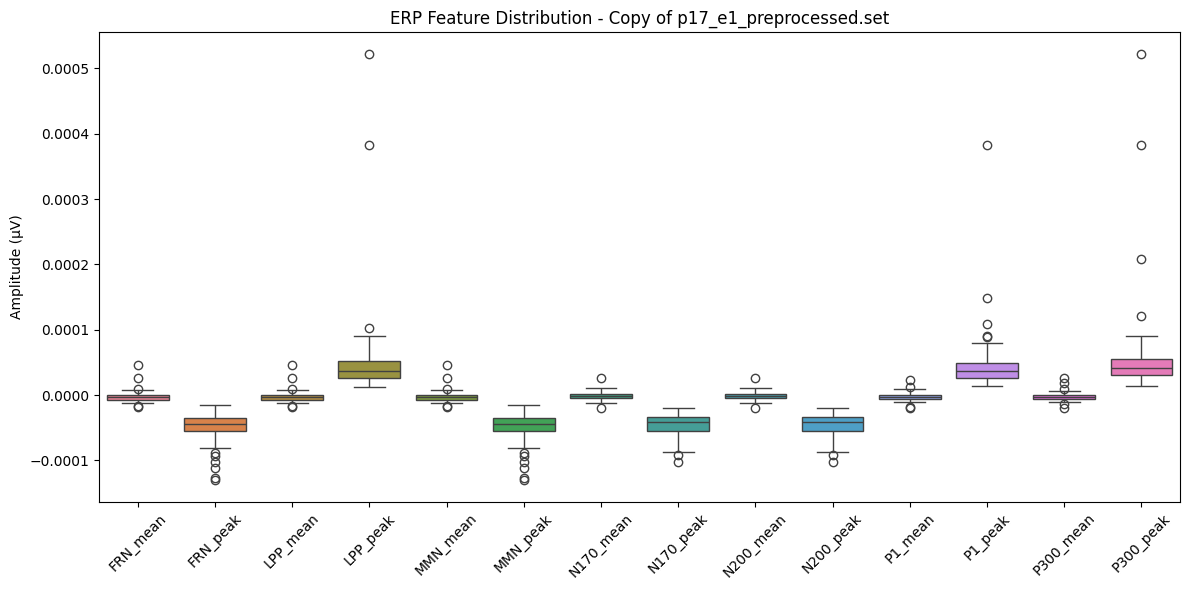

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Optional: Visualize ERP features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title(f"ERP Feature Distribution - {set_file}")
plt.xticks(rotation=45)
plt.ylabel("Amplitude (μV)")
plt.tight_layout()
plt.show()


In [ ]:
print(epochs.times)


[-1.    -0.996 -0.992 -0.988 -0.984 -0.98  -0.976 -0.972 -0.968 -0.964
 -0.96  -0.956 -0.952 -0.948 -0.944 -0.94  -0.936 -0.932 -0.928 -0.924
 -0.92  -0.916 -0.912 -0.908 -0.904 -0.9   -0.896 -0.892 -0.888 -0.884
 -0.88  -0.876 -0.872 -0.868 -0.864 -0.86  -0.856 -0.852 -0.848 -0.844
 -0.84  -0.836 -0.832 -0.828 -0.824 -0.82  -0.816 -0.812 -0.808 -0.804
 -0.8   -0.796 -0.792 -0.788 -0.784 -0.78  -0.776 -0.772 -0.768 -0.764
 -0.76  -0.756 -0.752 -0.748 -0.744 -0.74  -0.736 -0.732 -0.728 -0.724
 -0.72  -0.716 -0.712 -0.708 -0.704 -0.7   -0.696 -0.692 -0.688 -0.684
 -0.68  -0.676 -0.672 -0.668 -0.664 -0.66  -0.656 -0.652 -0.648 -0.644
 -0.64  -0.636 -0.632 -0.628 -0.624 -0.62  -0.616 -0.612 -0.608 -0.604
 -0.6   -0.596 -0.592 -0.588 -0.584 -0.58  -0.576 -0.572 -0.568 -0.564
 -0.56  -0.556 -0.552 -0.548 -0.544 -0.54  -0.536 -0.532 -0.528 -0.524
 -0.52  -0.516 -0.512 -0.508 -0.504 -0.5   -0.496 -0.492 -0.488 -0.484
 -0.48  -0.476 -0.472 -0.468 -0.464 -0.46  -0.456 -0.452 -0.448 -0.444
 -0.44

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials


In [ ]:
from google.colab import auth
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# Coherence

Coherence measures the functional connectivity between two EEG channels by quantifying how consistently they oscillate together at each frequency. It ranges from 0 (no synchrony) to 1 (perfect synchrony). elps detect communication between brain regions. Currently it calculates coherence without specifying a frequency range, so it computes coherence over the entire frequency range up to the Nyquist frequency (which is half the sampling rate sfreq).

In [ ]:
import mne
import numpy as np
import os
from scipy.signal import coherence
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set paths
dataset_path = "/content/dataset/"
results_dir = "/content/processed_results/"
coherence_dir = os.path.join(results_dir, "coherence")
os.makedirs(coherence_dir, exist_ok=True)

# Coherence function
def compute_channel_coherence(epochs, sfreq):
    data = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
    n_channels = data.shape[1]
    coh_matrix = np.zeros((n_channels, n_channels))

    # Average coherence across epochs
    for i in range(n_channels):
        for j in range(i+1, n_channels):
            coh_vals = []
            for ep in data:
                f, cxy = coherence(ep[i], ep[j], fs=sfreq)
                coh_vals.append(np.mean(cxy))
            coh_matrix[i, j] = np.mean(coh_vals)
            coh_matrix[j, i] = coh_matrix[i, j]  # symmetric

    return coh_matrix, f

# Loop through files
for set_file in set_files:
    file_path = os.path.join(dataset_path, set_file)
    try:
        epochs = mne.read_epochs_eeglab(file_path)
        sfreq = epochs.info['sfreq']
        ch_names = epochs.info['ch_names']

        coh_matrix, freqs = compute_channel_coherence(epochs, sfreq)
        df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)


        # Plot heatmap of the coherence matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(df, annot=False, cmap="coolwarm", vmin=0, vmax=1,
                    xticklabels=True, yticklabels=True, square=True, linewidths=0.5, cbar_kws={"label": "Coherence"})
        plt.title(f"Coherence Matrix - {set_file}")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()

        plt.show()  # ⬅️ Show the plot instead of saving


        # Save
        save_path = os.path.join(coherence_dir, f"{set_file[:-4]}_coherence.csv")
        df.to_csv(save_path)
        print(f"✅ Coherence saved for {set_file}")

    except Exception as e:
        print(f"❌ Failed for {set_file}: {e}")

❌ Failed for Copy of p4_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p4_e1_preprocessed.set"
❌ Failed for Copy of p8_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p8_e1_preprocessed.set"
❌ Failed for Copy of p15_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p15_e1_preprocessed.set"
❌ Failed for Copy of p7_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p7_e1_preprocessed.set"
❌ Failed for Copy of p13_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p13_e1_preprocessed.set"
❌ Failed for Copy of p12_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p12_e1_preprocessed.set"
❌ Failed for Copy of p1_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p1_e1_preprocessed.set"
❌ Failed for Copy of p10_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p10_e1_preprocessed.set"
❌ Failed for Copy of p18_e1_preprocessed.set: File does not exis

# Coherence Alpha Frontal

Alpha band (8–12 Hz) is often linked with relaxation, attention, and anxiety-related changes.Frontal regions (F3, F4, Fz) are important in emotional regulation, attention, and cognitive control. alpha-band coherence values between frontal channels is calculated


In [ ]:
import mne
import numpy as np
import os
from scipy.signal import coherence
import pandas as pd

# Set paths
coherence_dir = os.path.join(results_dir, "coherence_alpha_frontal")
os.makedirs(coherence_dir, exist_ok=True)

# Alpha frontal coherence function
def compute_alpha_frontal_coherence(epochs, sfreq):
    data = epochs.get_data()
    ch_names = epochs.info['ch_names']
    frontal_channels = ['F3', 'F4', 'Fz']

    # Find indices of those channels
    ch_indices = [ch_names.index(ch) for ch in frontal_channels if ch in ch_names]
    n_channels = len(ch_indices)
    coh_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i+1, n_channels):
            coh_vals = []
            for ep in data:
                f, cxy = coherence(ep[ch_indices[i]], ep[ch_indices[j]], fs=sfreq)
                band_mask = (f >= 8) & (f <= 12)  # Alpha band
                coh_vals.append(np.mean(cxy[band_mask]))
            coh_matrix[i, j] = np.mean(coh_vals)
            coh_matrix[j, i] = coh_matrix[i, j]

    selected_names = [ch_names[i] for i in ch_indices]
    return coh_matrix, selected_names

# Loop through files
for set_file in set_files:
    file_path = os.path.join(dataset_path, set_file)
    try:
        epochs = mne.read_epochs_eeglab(file_path)
        sfreq = epochs.info['sfreq']

        coh_matrix, selected_names = compute_alpha_frontal_coherence(epochs, sfreq)
        df = pd.DataFrame(coh_matrix, index=selected_names, columns=selected_names)
        plt.figure(figsize=(6, 5))
        sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1,
                    xticklabels=True, yticklabels=True, square=True, linewidths=0.5, cbar_kws={"label": "Alpha Coherence"})
        plt.title(f"Alpha Frontal Coherence - {set_file}")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()

        plt.show()
        # Save
        save_path = os.path.join(coherence_dir, f"{set_file[:-4]}_alpha_frontal_coherence.csv")
        df.to_csv(save_path)
        print(f"✅ Alpha frontal coherence saved for {set_file}")

    except Exception as e:
        print(f"❌ Failed for {set_file}: {e}")


❌ Failed for Copy of p4_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p4_e1_preprocessed.set"
❌ Failed for Copy of p8_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p8_e1_preprocessed.set"
❌ Failed for Copy of p15_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p15_e1_preprocessed.set"
❌ Failed for Copy of p7_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p7_e1_preprocessed.set"
❌ Failed for Copy of p13_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p13_e1_preprocessed.set"
❌ Failed for Copy of p12_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p12_e1_preprocessed.set"
❌ Failed for Copy of p1_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p1_e1_preprocessed.set"
❌ Failed for Copy of p10_e1_preprocessed.set: File does not exist: "/content/dataset/Copy of p10_e1_preprocessed.set"
❌ Failed for Copy of p18_e1_preprocessed.set: File does not exis

In [13]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def upload_to_drive(local_path, drive_folder_id):
    if os.path.isfile(local_path):
        gfile = drive.CreateFile({'parents': [{'id': drive_folder_id}]})
        gfile.SetContentFile(local_path)
        gfile.Upload()
        print(f'Uploaded file: {os.path.basename(local_path)}')
    elif os.path.isdir(local_path):
        # Create folder in Drive
        folder_name = os.path.basename(local_path)
        folder_metadata = {
            'title': folder_name,
            'mimeType': 'application/vnd.google-apps.folder',
            'parents': [{'id': drive_folder_id}]
        }
        drive_folder = drive.CreateFile(folder_metadata)
        drive_folder.Upload()

        # Upload contents
        for item in os.listdir(local_path):
            item_path = os.path.join(local_path, item)
            if os.path.isfile(item_path):
                gfile = drive.CreateFile({'parents': [{'id': drive_folder['id']}]})
                gfile.SetContentFile(item_path)
                gfile.Upload()
                print(f'Uploaded: {item}')


drive_folder_id = '1w_eKASLrFx6ToEaQWjDqMVNNLeDraDN5'

# Upload ERP and coherence
#upload_to_drive('/content/processed_results/coherence', drive_folder_id)
upload_to_drive('/content/processed_results_4/ERP_for_all', drive_folder_id)

print("\n✅ Upload complete! Check your Google Drive folder.")

Uploaded: p1_e2_preprocessed_erp_all_channels.csv
Uploaded: p12_e2_preprocessed_erp_all_channels.csv
Uploaded: p18_e2_preprocessed_erp_all_channels.csv
Uploaded: p39_e2_preprocessed_erp_all_channels.csv
Uploaded: p48_e2_preprocessed_erp_all_channels.csv


KeyboardInterrupt: 

In [ ]:
upload_to_drive('ERP', drive_folder_id)